# Neural networks auto-differentiation using PyTorch 2.0

Before running this notebook, you must run `training.ipynb` in order to generate the function and the network that will be loaded and derived in this notebook. Note that the tools that will be use are only available for `torch >= 2.0`.

In [235]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(''), ".."))

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.func import jacrev, hessian, vmap

from nnbma.networks import NeuralNetwork

## Introduction to differentiation with PyTorch

We will use the following modules:
* `jacrev`: compute the jacobian using reverse-mode autodiff
* `jacfwd`: compute the jacobian using forward-mode autodiff
* `hessian`: compute the jacobian using both reverse and forward-mode autodiff
* `vmap`: vectorizing function used to compute the derivatives of batched inputs

The computation of high order derivative can be done by composing several times `jacrev` and/or `jacfwd`. Note that `hessian` is just a convenience module defined as `hessian(f) = jacfwd(jacrev(f))`, but that the hessian computation can be done through other compositions.

## Import of the analytical function

In the following cell, we will import the vectorial function $ f: \left(\begin{array}{c} t_1\\ t_2 \end{array}\right) \longmapsto \left(\begin{array}{c} t_1+2t_2\\ t_1^2\\ t_1t_2^2 \end{array}\right) $.

Please refer to `training.ipynb` for more details on it.

In [236]:
from functions import F

f = F()

ranges = [(-2., 2.), (-1., 1.)] # Range of values of all inputs of f. Can be modified but must be consistent with the imported function.

n_points = 100 # Number of points needed to plot a profile

default_values = [0., 0.] # Default values of all inputs of f when plotting a profile. Can be modified but must be consistent with the imported function.

## Loading of the trained network

In [237]:
path = os.path.join(os.path.splitext(os.path.abspath(''))[0], "out-training")

net = NeuralNetwork.load("network", path)
net.double().eval() # TODO
print(net)

FullyConnected:
	layers_sizes: [2, 100, 100, 3]
	activation: GELU(approximate='none')
	batch_norm: False
	inputs_names: None
	outputs_names: None
	inputs_transformer: None
	outputs_transformer: None
	device: cpu
	last_restrictable: True



## Differentiation of the analytical function

In this part, we will compute the first and second order derivatives of the analytical function defined in `training.ipynb`. As the number of possible plots explodes when we differentiate a vectorial function several times, we will chose to represent only the evolution of a single output versus only one or two variables.

In [238]:
# Index of free input when plotting profiles, the others being restricted to their default value.
input_to_plot = 1 # Must be between 1 and f.n_inputs

# Index of free inputs when drawing bivariate plots, the others being restricted to their default value.
inputs_to_plot = (1, 2) # Must be between 1 and f.n_inputs

# Index of the output to plot.
output_to_plot = 3 # Must be between 1 and f.n_outputs

In [239]:
jacobian_f = vmap(jacrev(f))
hessian_f = vmap(hessian(f))

### Profiles of first and second order derivatives

In [240]:
x = np.array(default_values) * np.ones((n_points, f.n_inputs), dtype="float")
x[:, input_to_plot-1] = np.linspace(*ranges[input_to_plot-1], n_points)
print("x.shape:", x.shape)

dy = jacobian_f(torch.from_numpy(x)).detach().numpy()
print("dy.shape:", dy.shape)

ddy = hessian_f(torch.from_numpy(x)).detach().numpy()
print("ddy.shape:", ddy.shape)

x.shape: (100, 2)
dy.shape: (100, 3, 2)
ddy.shape: (100, 3, 2, 2)


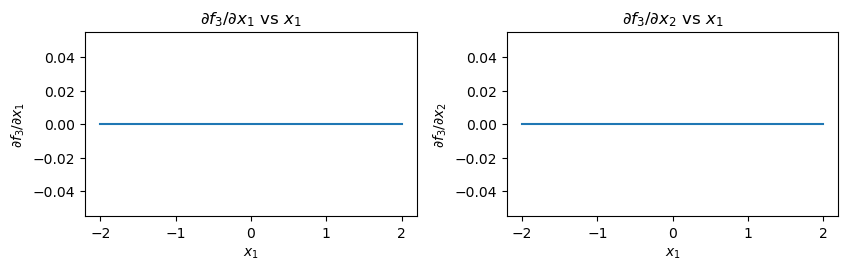

In [241]:
plt.figure(figsize=(f.n_inputs*6.4, 4.8))

for i in range(f.n_inputs):

    plt.subplot(f.n_inputs, f.n_outputs, i+1)

    plt.plot(x[:, input_to_plot-1], dy[:, output_to_plot-1, i])

    plt.xlabel(f"$x_{input_to_plot}$")
    plt.ylabel(f"$\\partial f_{output_to_plot} / \\partial x_{i+1}$")
    plt.title(f"$\\partial f_{output_to_plot} / \\partial x_{i+1}$ vs $x_{input_to_plot}$")

plt.tight_layout()

plt.show()

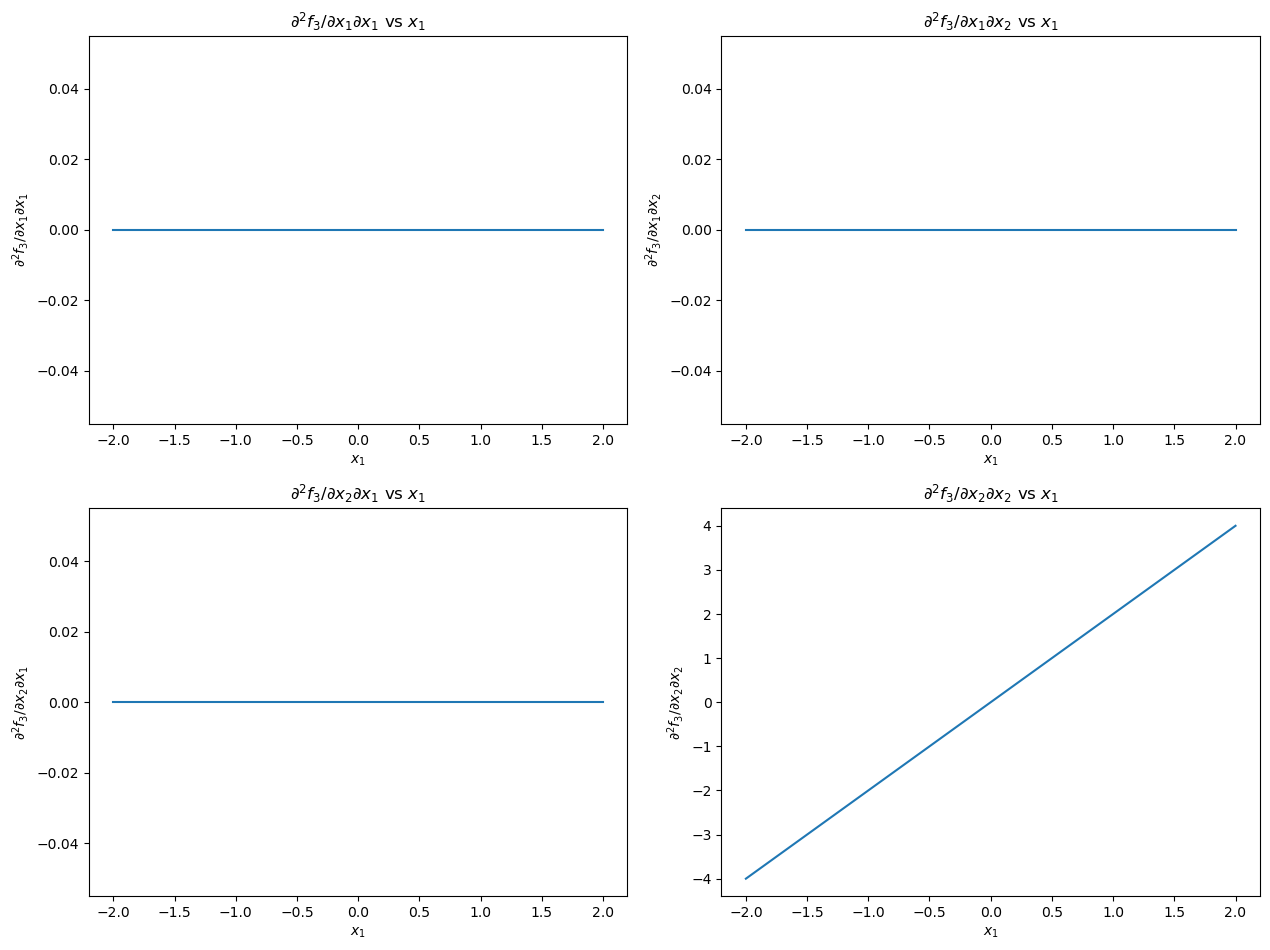

In [242]:
plt.figure(figsize=(f.n_inputs*6.4, f.n_inputs*4.8))

for i1 in range(f.n_inputs):

    for i2 in range(f.n_inputs):

        plt.subplot(f.n_inputs, f.n_inputs, i1*f.n_inputs+i2+1)

        plt.plot(x[:, input_to_plot-1], ddy[:, output_to_plot-1, i1, i2])

        plt.xlabel(f"$x_{input_to_plot}$")
        plt.ylabel(f"$\\partial^2 f_{output_to_plot} / \\partial x_{i1+1} \\partial x_{i2+1}$")
        plt.title(f"$\\partial^2 f_{output_to_plot} / \\partial x_{i1+1} \\partial x_{i2+1}$ vs $x_{input_to_plot}$")

plt.tight_layout()

plt.show()

### Bivariate plots of first and second order derivatives

In [244]:
X = np.dstack(np.meshgrid(
    *[np.linspace(*ranges[i], n_points) if i+1 in inputs_to_plot else default_values[i] * np.ones(n_points) for i in range(f.n_inputs)]
))
print("X.shape:", X.shape)

dY = jacobian_f(torch.from_numpy(X.reshape(n_points**2, f.n_inputs))).detach().numpy().reshape(n_points, n_points, f.n_outputs, f.n_inputs)
print("dY.shape:", dY.shape)

ddY = hessian_f(torch.from_numpy(X.reshape(n_points**2, f.n_inputs))).detach().numpy().reshape(n_points, n_points, f.n_outputs, f.n_inputs, f.n_inputs)
print("ddY.shape:", ddY.shape)

X.shape: (100, 100, 2)
dY.shape: (100, 100, 3, 2)
ddY.shape: (100, 100, 3, 2, 2)


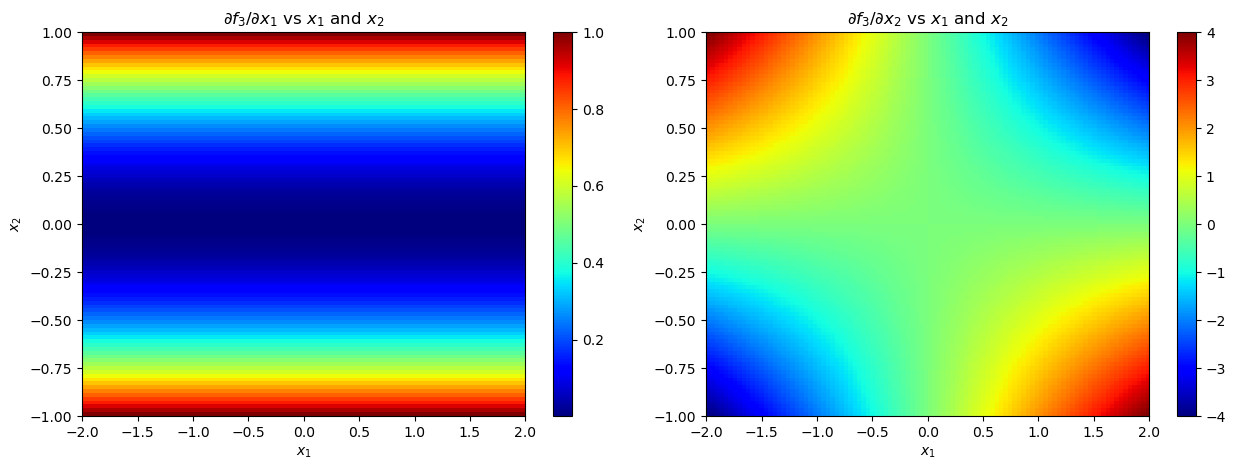

In [245]:
plt.figure(figsize=(6.4*f.n_inputs, 4.8))

for i in range(f.n_inputs):
    plt.subplot(1, f.n_inputs, i+1)
    plt.imshow(
        dY[:, :, output_to_plot-1, i], cmap="jet", aspect="auto", extent=[
            ranges[inputs_to_plot[0]-1][0], ranges[inputs_to_plot[0]-1][1],
            ranges[inputs_to_plot[1]-1][0], ranges[inputs_to_plot[1]-1][1],
        ],
    )
    plt.colorbar()

    plt.xlabel(f"$x_{inputs_to_plot[0]}$")
    plt.ylabel(f"$x_{inputs_to_plot[1]}$")
    plt.title(f"$\\partial f_{output_to_plot} / \\partial x_{i+1}$ vs $x_{inputs_to_plot[0]}$ and $x_{inputs_to_plot[1]}$")

plt.tight_layout()

plt.show()

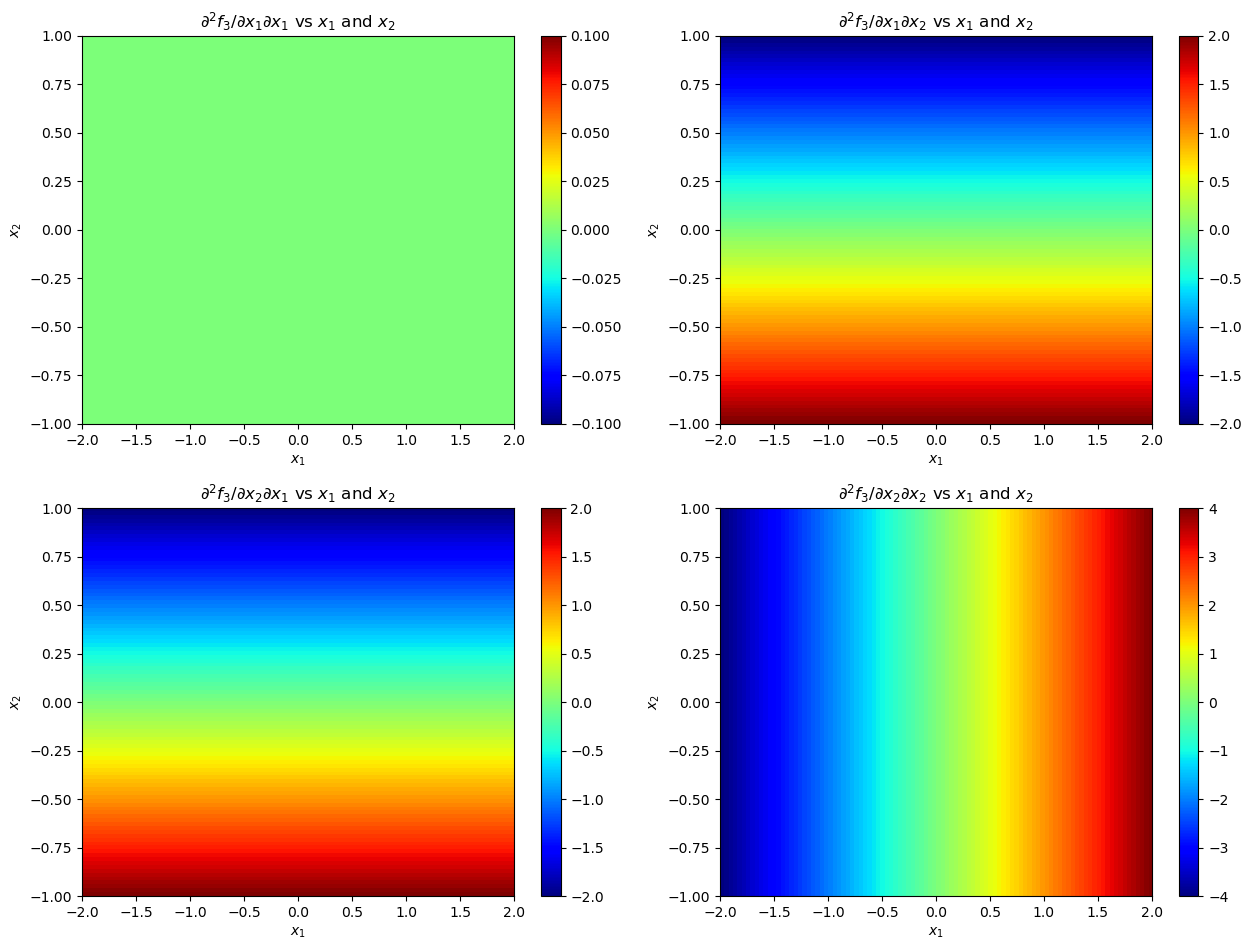

In [246]:
plt.figure(figsize=(6.4*f.n_inputs, f.n_inputs*4.8))

for i1 in range(f.n_inputs):

    for i2 in range(f.n_inputs):

        plt.subplot(f.n_inputs, f.n_inputs, i1*f.n_inputs+i2+1)
        plt.imshow(
            ddY[:, :, output_to_plot-1, i1, i2], cmap="jet", aspect="auto", extent=[
                ranges[inputs_to_plot[0]-1][0], ranges[inputs_to_plot[0]-1][1],
                ranges[inputs_to_plot[1]-1][0], ranges[inputs_to_plot[1]-1][1],
            ],
        )
        plt.colorbar()

        plt.xlabel(f"$x_{inputs_to_plot[0]}$")
        plt.ylabel(f"$x_{inputs_to_plot[1]}$")
        plt.title(f"$\\partial^2 f_{output_to_plot} / \\partial x_{i1+1} \\partial x_{i2+1}$ vs $x_{inputs_to_plot[0]}$ and $x_{inputs_to_plot[1]}$")

plt.tight_layout()

plt.show()

## Differentiation of the neural network

We will now compute the first and second order derivatives of a neural network that has been trained to approximate the previous function.

In [247]:
jacobian_net = vmap(jacrev(net))
hessian_net = vmap(hessian(net))

### Profiles of first and second order derivatives

In [248]:
x = np.array(default_values) * np.ones((n_points, f.n_inputs), dtype="float")
x[:, input_to_plot-1] = np.linspace(*ranges[input_to_plot-1], n_points)
print("x.shape:", x.shape)

dy_net = jacobian_net(torch.from_numpy(x)).detach().numpy()
print("dy.shape:", dy.shape)

ddy_net = hessian_net(torch.from_numpy(x)).detach().numpy()
print("ddy.shape:", ddy.shape)

x.shape: (100, 2)
dy.shape: (100, 3, 2)
ddy.shape: (100, 3, 2, 2)


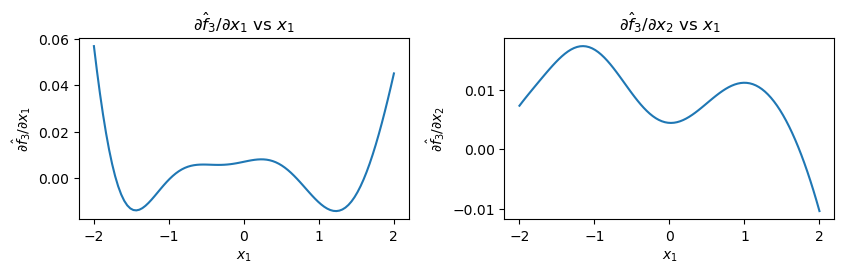

In [249]:
plt.figure(figsize=(f.n_inputs*6.4, 4.8))

for i in range(f.n_inputs):

    plt.subplot(f.n_inputs, f.n_outputs, i+1)

    plt.plot(x[:, input_to_plot-1], dy_net[:, output_to_plot-1, i])

    plt.xlabel(f"$x_{input_to_plot}$")
    plt.ylabel(f"$\\partial \\hat{{f}}_{output_to_plot} / \\partial x_{i+1}$")
    plt.title(f"$\\partial \\hat{{f}}_{output_to_plot} / \\partial x_{i+1}$ vs $x_{input_to_plot}$")

plt.tight_layout()

plt.show()

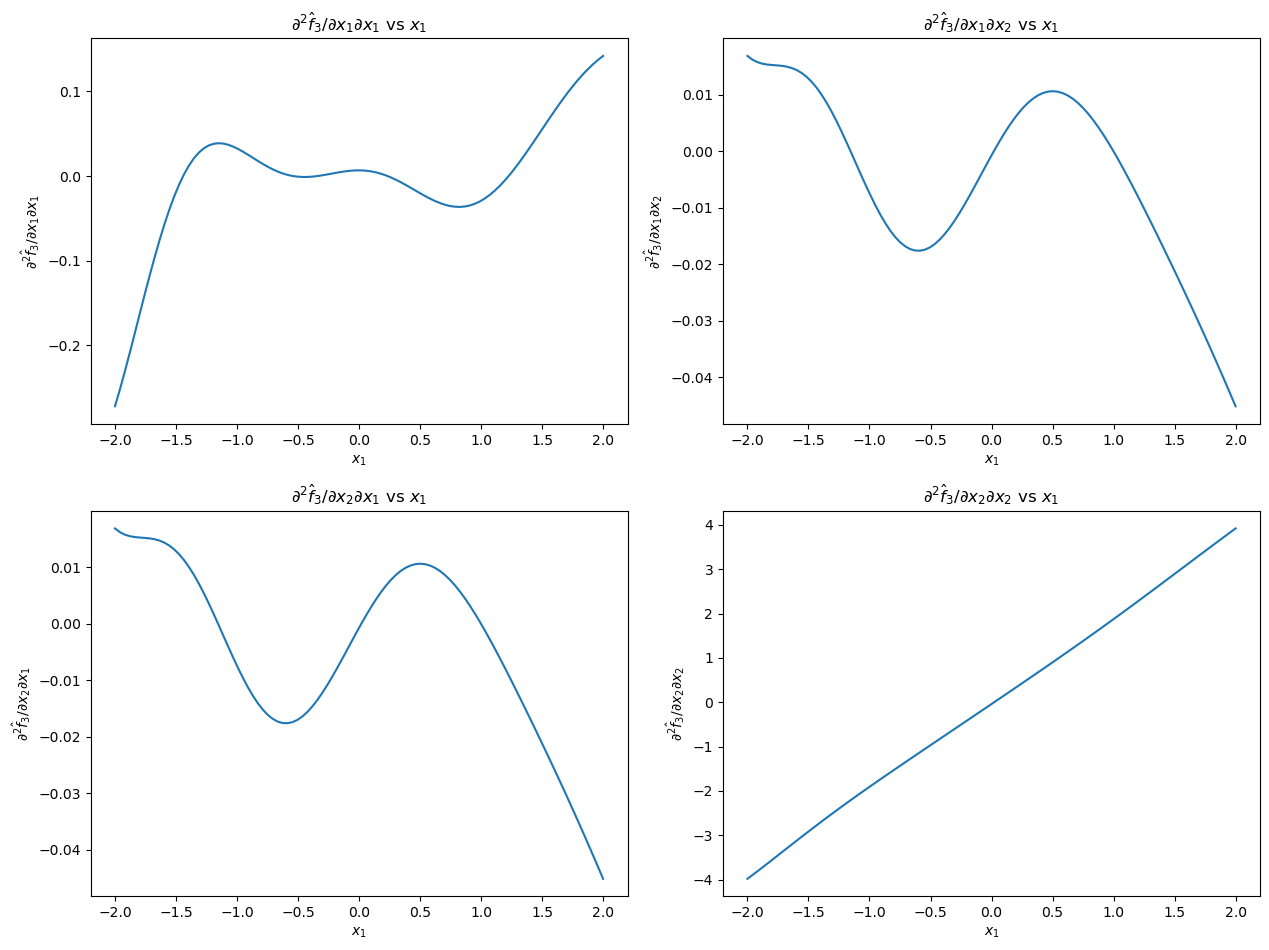

In [250]:
plt.figure(figsize=(f.n_inputs*6.4, f.n_inputs*4.8))

for i1 in range(f.n_inputs):

    for i2 in range(f.n_inputs):

        plt.subplot(f.n_inputs, f.n_inputs, i1*f.n_inputs+i2+1)

        plt.plot(x[:, input_to_plot-1], ddy_net[:, output_to_plot-1, i1, i2])

        plt.xlabel(f"$x_{input_to_plot}$")
        plt.ylabel(f"$\\partial^2 \\hat{{f}}_{output_to_plot} / \\partial x_{i1+1} \\partial x_{i2+1}$")
        plt.title(f"$\\partial^2 \\hat{{f}}_{output_to_plot} / \\partial x_{i1+1} \\partial x_{i2+1}$ vs $x_{input_to_plot}$")

plt.tight_layout()

plt.show()

### Bivariate plots of first and second order derivatives

In [251]:
X = np.dstack(np.meshgrid(
    *[np.linspace(*ranges[i], n_points) if i+1 in inputs_to_plot else default_values[i] * np.ones(n_points) for i in range(f.n_inputs)]
))
print("X.shape:", X.shape)

dY_net = jacobian_net(torch.from_numpy(X.reshape(n_points**2, f.n_inputs))).detach().numpy().reshape(n_points, n_points, f.n_outputs, f.n_inputs)
print("dY.shape:", dY.shape)

ddY_net = hessian_net(torch.from_numpy(X.reshape(n_points**2, f.n_inputs))).detach().numpy().reshape(n_points, n_points, f.n_outputs, f.n_inputs, f.n_inputs)
print("ddY.shape:", ddY.shape)

X.shape: (100, 100, 2)
dY.shape: (100, 100, 3, 2)
ddY.shape: (100, 100, 3, 2, 2)


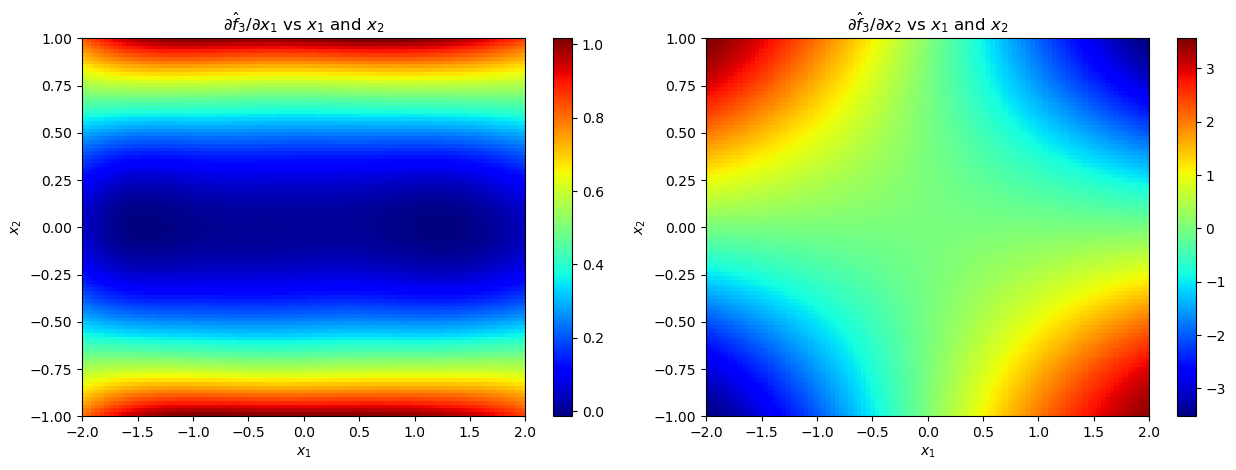

In [252]:
plt.figure(figsize=(6.4*f.n_inputs, 4.8))

for i in range(f.n_inputs):
    plt.subplot(1, f.n_inputs, i+1)
    plt.imshow(
        dY_net[:, :, output_to_plot-1, i], cmap="jet", aspect="auto", extent=[
            ranges[inputs_to_plot[0]-1][0], ranges[inputs_to_plot[0]-1][1],
            ranges[inputs_to_plot[1]-1][0], ranges[inputs_to_plot[1]-1][1],
        ],
    )
    plt.colorbar()

    plt.xlabel(f"$x_{inputs_to_plot[0]}$")
    plt.ylabel(f"$x_{inputs_to_plot[1]}$")
    plt.title(f"$\\partial \\hat{{f}}_{output_to_plot} / \\partial x_{i+1}$ vs $x_{inputs_to_plot[0]}$ and $x_{inputs_to_plot[1]}$")

plt.tight_layout()

plt.show()

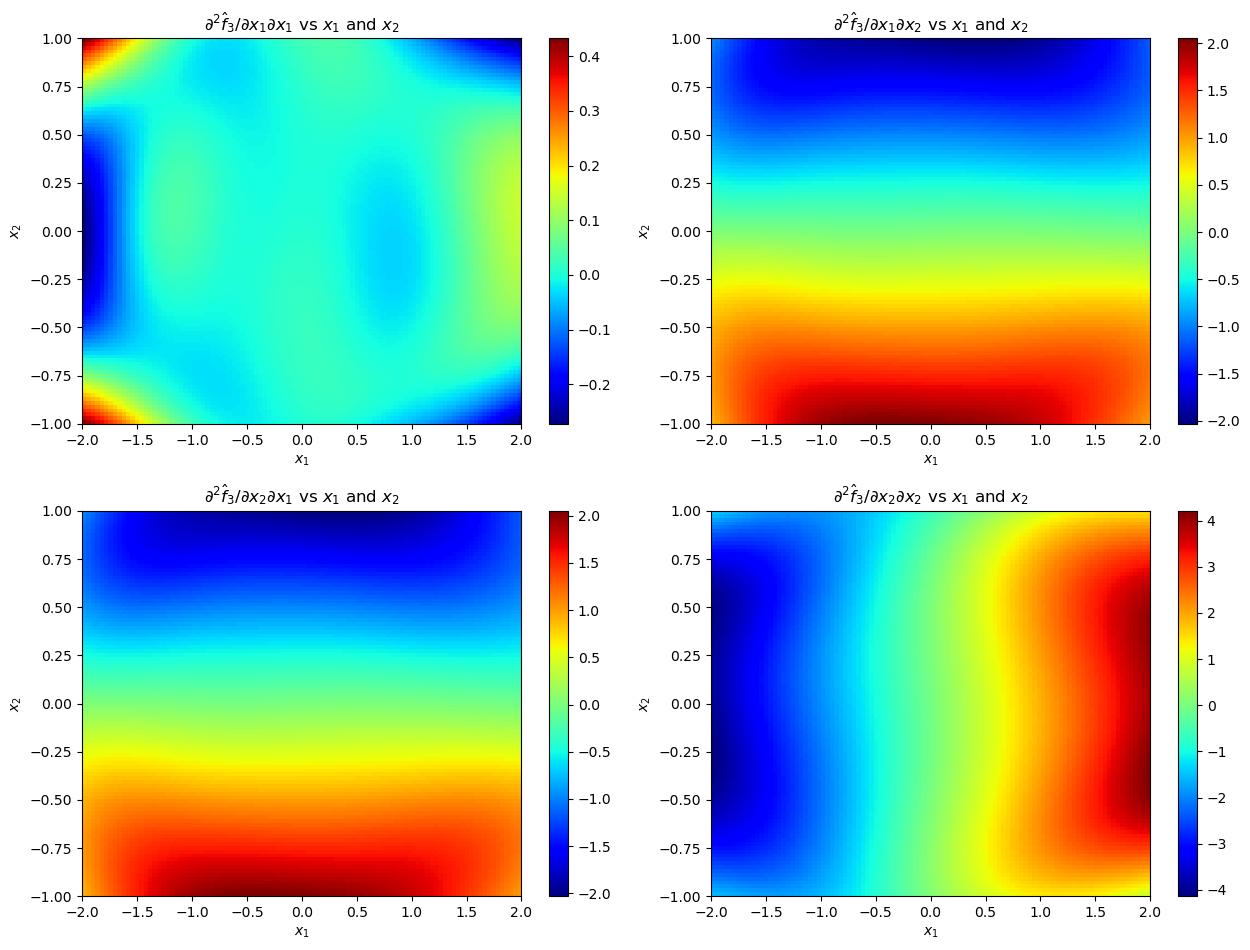

In [253]:
plt.figure(figsize=(6.4*f.n_inputs, f.n_inputs*4.8))

for i1 in range(f.n_inputs):

    for i2 in range(f.n_inputs):

        plt.subplot(f.n_inputs, f.n_inputs, i1*f.n_inputs+i2+1)
        plt.imshow(
            ddY_net[:, :, output_to_plot-1, i1, i2], cmap="jet", aspect="auto", extent=[
                ranges[inputs_to_plot[0]-1][0], ranges[inputs_to_plot[0]-1][1],
                ranges[inputs_to_plot[1]-1][0], ranges[inputs_to_plot[1]-1][1],
            ],
        )
        plt.colorbar()

        plt.xlabel(f"$x_{inputs_to_plot[0]}$")
        plt.ylabel(f"$x_{inputs_to_plot[1]}$")
        plt.title(f"$\\partial^2 \\hat{{f}}_{output_to_plot} / \\partial x_{i1+1} \\partial x_{i2+1}$ vs $x_{inputs_to_plot[0]}$ and $x_{inputs_to_plot[1]}$")

plt.tight_layout()

plt.show()

## Errors of approximated derivatives

In [254]:
relative = True
eps = 1e-2

### Profiles of first and second order derivatives

In [255]:
error_dy = (dy_net - dy) / (np.abs(dy)+eps) if relative else dy_net - dy
print("error_dy.shape:", error_dy.shape)

error_ddy = (ddy_net - ddy) / (np.abs(ddy)+eps) if relative else ddy_net - ddy
print("error_ddy.shape:", error_ddy.shape)

error_dy.shape: (100, 3, 2)
error_ddy.shape: (100, 3, 2, 2)


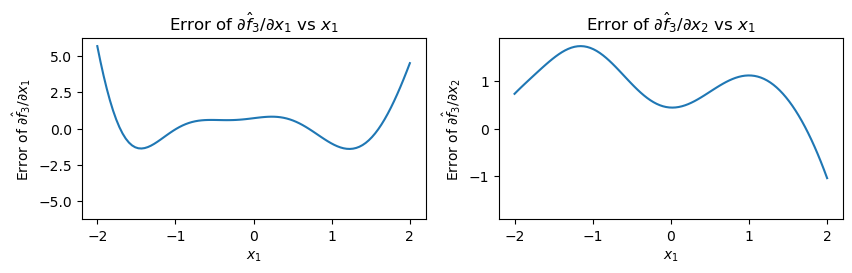

In [256]:
plt.figure(figsize=(f.n_inputs*6.4, 4.8))

for i in range(f.n_inputs):
        
    vmax = np.abs(error_dy[:, output_to_plot-1, i]).max()

    plt.subplot(f.n_inputs, f.n_outputs, i+1)

    plt.plot(x[:, input_to_plot-1], error_dy[:, output_to_plot-1, i])
    plt.ylim([-1.1*vmax, 1.1*vmax])

    plt.xlabel(f"$x_{input_to_plot}$")
    plt.ylabel(f"Error of $\\partial \\hat{{f}}_{output_to_plot} / \\partial x_{i+1}$")
    plt.title(f"Error of $\\partial \\hat{{f}}_{output_to_plot} / \\partial x_{i+1}$ vs $x_{input_to_plot}$")

plt.tight_layout()

plt.show()

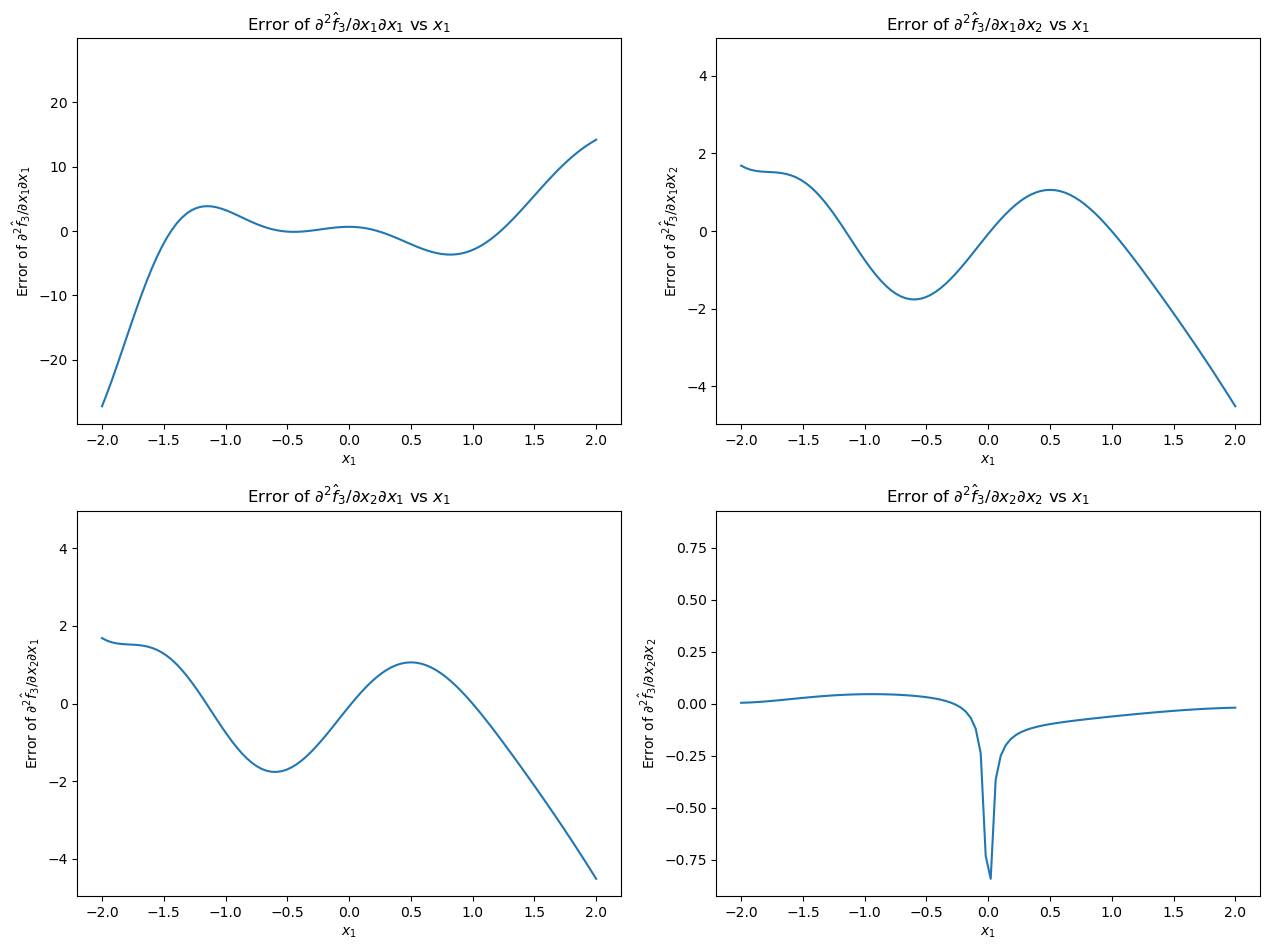

In [257]:
plt.figure(figsize=(f.n_inputs*6.4, f.n_inputs*4.8))

for i1 in range(f.n_inputs):

    for i2 in range(f.n_inputs):

        vmax = np.abs(error_ddy[:, output_to_plot-1, i1, i2]).max()

        plt.subplot(f.n_inputs, f.n_inputs, i1*f.n_inputs+i2+1)

        plt.plot(x[:, input_to_plot-1], error_ddy[:, output_to_plot-1, i1, i2])
        plt.ylim([-1.1*vmax, 1.1*vmax])

        plt.xlabel(f"$x_{input_to_plot}$")
        plt.ylabel(f"Error of $\\partial^2 \\hat{{f}}_{output_to_plot} / \\partial x_{i1+1} \\partial x_{i2+1}$")
        plt.title(f"Error of $\\partial^2 \\hat{{f}}_{output_to_plot} / \\partial x_{i1+1} \\partial x_{i2+1}$ vs $x_{input_to_plot}$")

plt.tight_layout()

plt.show()

### Bivariate plots of first and second order derivatives

In [258]:
Error_dY = (dY_net - dY) / (np.abs(dY)+eps) if relative else dY_net - dY
print("Error_dY.shape:", dY.shape)

Error_ddY = (ddY_net - ddY) / (np.abs(ddY)+eps) if relative else ddY_net - ddY
print("Error_ddY.shape:", ddY.shape)

Error_dY.shape: (100, 100, 3, 2)
Error_ddY.shape: (100, 100, 3, 2, 2)


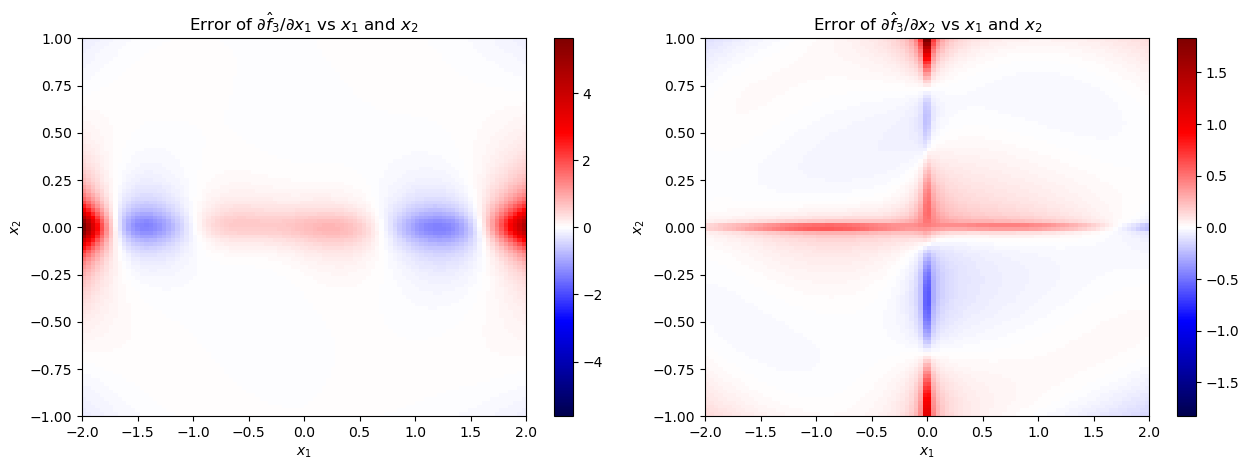

In [259]:
plt.figure(figsize=(6.4*f.n_inputs, 4.8))

for i in range(f.n_inputs):
            
    vmax = np.abs(Error_dY[:, :, output_to_plot-1, i]).max()

    plt.subplot(1, f.n_inputs, i+1)
    plt.imshow(
        Error_dY[:, :, output_to_plot-1, i], cmap="seismic", aspect="auto", extent=[
            ranges[inputs_to_plot[0]-1][0], ranges[inputs_to_plot[0]-1][1],
            ranges[inputs_to_plot[1]-1][0], ranges[inputs_to_plot[1]-1][1],
        ], vmin=-vmax, vmax=vmax,
    )
    plt.colorbar()

    plt.xlabel(f"$x_{inputs_to_plot[0]}$")
    plt.ylabel(f"$x_{inputs_to_plot[1]}$")
    plt.title(f"Error of $\\partial \\hat{{f}}_{output_to_plot} / \\partial x_{i+1}$ vs $x_{inputs_to_plot[0]}$ and $x_{inputs_to_plot[1]}$")

plt.tight_layout()

plt.show()

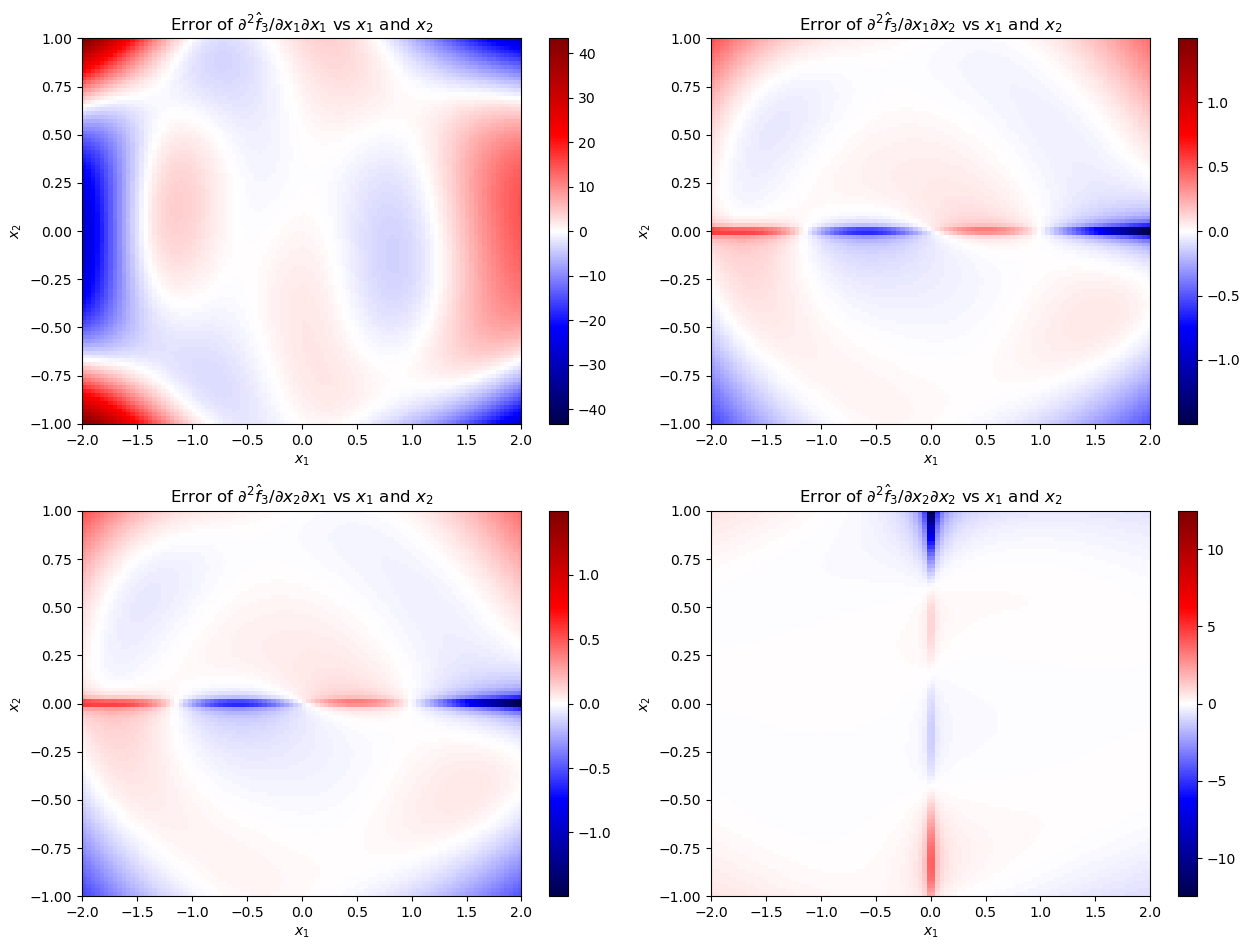

In [260]:
plt.figure(figsize=(6.4*f.n_inputs, f.n_inputs*4.8))

for i1 in range(f.n_inputs):

    for i2 in range(f.n_inputs):

        vmax = np.abs(Error_ddY[:, :, output_to_plot-1, i1, i2]).max()

        plt.subplot(f.n_inputs, f.n_inputs, i1*f.n_inputs+i2+1)
        plt.imshow(
            Error_ddY[:, :, output_to_plot-1, i1, i2], cmap="seismic", aspect="auto", extent=[
                ranges[inputs_to_plot[0]-1][0], ranges[inputs_to_plot[0]-1][1],
                ranges[inputs_to_plot[1]-1][0], ranges[inputs_to_plot[1]-1][1],
            ], vmin=-vmax, vmax=vmax,
        )
        plt.colorbar()

        plt.xlabel(f"$x_{inputs_to_plot[0]}$")
        plt.ylabel(f"$x_{inputs_to_plot[1]}$")
        plt.title(f"Error of $\\partial^2 \\hat{{f}}_{output_to_plot} / \\partial x_{i1+1} \\partial x_{i2+1}$ vs $x_{inputs_to_plot[0]}$ and $x_{inputs_to_plot[1]}$")

plt.tight_layout()

plt.show()